<a href="https://colab.research.google.com/github/hassaanseeker/ML_Notebooks/blob/master/Trivago_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING ALL REQUIRED LIBRARIES**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from xgboost import plot_importance
import lightgbm as lgb
# from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
import sklearn

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
## Reading the Data-Set
data = pd.read_csv('gdrive/My Drive/kaggle_challenges/ML Data Scientist Case Study Data.csv', sep = ";")

In [0]:
def data_missing_hit_split(data):
  """Function for splitting the Train And Test Date"""
  data_train = data[data['hits'] != r'\N'].reset_index().drop(columns = {'index'})
  data_test = data[data['hits'] == r'\N'].reset_index().drop(columns = {'index'})

    ## Unit Test for checking the split was Ok.
  if data_train.shape[0] + data_test.shape[0] == data.shape[0]:
    print('Data split OK...')
    return data_train, data_test

In [33]:
data_train, data_test = data_missing_hit_split(data)

Data split OK...


In [47]:
data.groupby(['day_of_week']).hits.count() ## Checking if there is any imbalance in the Data-Set

day_of_week
Friday       127740
Monday       158685
Saturday     119350
Sunday       144330
Thursday     136476
Tuesday      155001
Wednesday    147099
Name: hits, dtype: int64

In [0]:
def bar_chart(data, groupby_parameter):
  """Function for plotting bar-charts to check if there is any imbalance in the Data-Set"""
  objects = tuple(dict(data.groupby([groupby_parameter]).hits.count()).keys())
  y_pos = np.arange(len(objects))
    
  count = list(dict(data_train.groupby([groupby_parameter]).hits.count()).values())
  plt.bar(y_pos, count, align = 'center', alpha = 0.5)
  plt.xticks(y_pos, objects)

  plt.show()

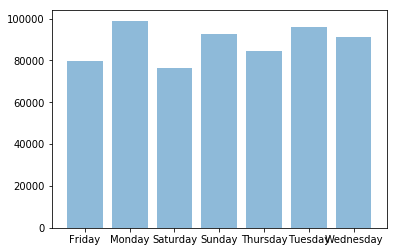

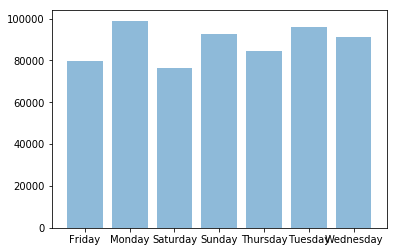

In [0]:
bar_chart(data_train, 'day_of_week')
bar_chart(data_test, 'day_of_week')

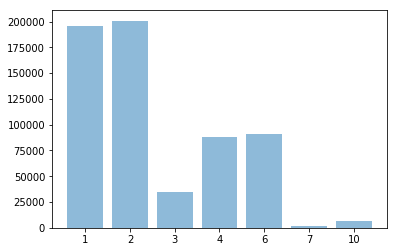

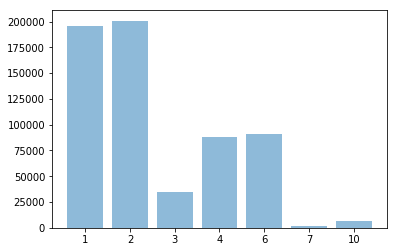

In [0]:
bar_chart(data_train, 'traffic_type')
bar_chart(data_test, 'traffic_type')

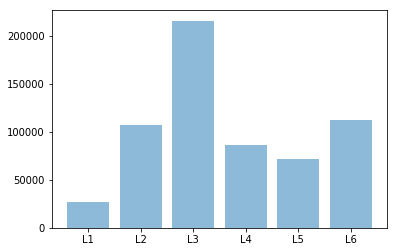

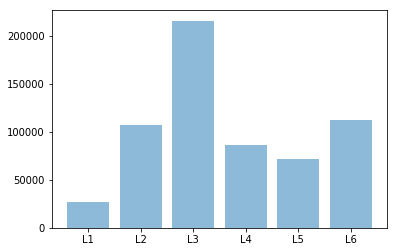

In [0]:
bar_chart(data_train, 'locale')
bar_chart(data_test, 'locale')

**As we can see from the above plots there are some imbalances in the classes. We will consider this in feature engineering.**

**FEATURE-ENGINEERING**

In [0]:
data_train = data_train[data_train['path_id_set'].isnull() == False]
data_test = data_test[data_test['path_id_set'].isnull() == False]

In [49]:
data_train.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
0,988680,L2,Thursday,22,10,2113,31965;0,2,49,14
1,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14
2,988678,L3,Saturday,19,8,2113,51462,6,0,1
3,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3
4,988676,L3,Monday,1,8,2100,0,1,0,2


In [0]:
data_train = data_train[data_train['session_durantion'] != '\\N'] ## removing null values from session_duration
data_test = data_test[data_test['session_durantion'] != '\\N']

data_train['hits'] = data_train['hits'].astype('int') ## Converting hits column to integer
data_train = data_train[data_train['hits'] <= 1000]

## Creating a new binary column where if 0 then no location visited else 1 if visited.
data_train.loc[data_train.path_id_set == '0', 'loc_visited'] = 0 
data_train['loc_visited'] = data_train['loc_visited'].fillna(1)
data_test.loc[data_test.path_id_set == '0', 'loc_visited'] = 0 
data_test['loc_visited'] = data_test['loc_visited'].fillna(1)


## Get count if visited any location or not variable name zero count which represents wether a location was visited or not.
zero_count = data_train['path_id_set'].str.split(';', n = 133, expand = True).isin({'0'}).sum(1)
zero_count_test = data_test['path_id_set'].str.split(';', n = 133, expand = True).isin({'0'}).sum(1)


## Creating a new columns where we add all postal codes together to get one single value.
data_train['all_loc_sum'] = data_train['path_id_set'].str.split(';', n= 133, expand = True).fillna(0).astype('int').sum(axis = 1)
data_test['all_loc_sum'] = data_test['path_id_set'].str.split(';', n= 133, expand = True).fillna(0).astype('int').sum(axis = 1)

In [0]:
def custom_encoding_ordinal_categorical_variables_day_of_week(data):
    
    """Seeing according to ISO 8601 Monday is the first day
    in a week we create the below dictionary for categorical variable"""
    
    day_dic = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
    data['day_of_week'] = data['day_of_week'].replace(day_dic)
    
    return data

In [0]:
def custom_encoding_ordinal_categorical_variables_locale(data):
    
    """Seeing from above that different locale are having different
        hits count so we need to treat them as ordinal categorical variables"""
    
    locale_dic = {'L1': 1, 'L2': 2, 'L3': 3, 'L4': 4, 'L5': 5, 'L6': 6}
    data['locale'] = data['locale'].replace(locale_dic)
    
    return data

In [0]:
custom_encoding_ordinal_categorical_variables_day_of_week(data_train)
custom_encoding_ordinal_categorical_variables_locale(data_train)
custom_encoding_ordinal_categorical_variables_day_of_week(data_test)
custom_encoding_ordinal_categorical_variables_locale(data_test)

In [0]:
## Column for total number of locations visited.
data_train['num_loc_visits'] = (data_train['path_id_set'].str.count(';') + 1) - zero_count
data_test['num_loc_visits'] = (data_test['path_id_set'].str.count(';') + 1) - zero_count_test

## Dropping the column path_id_set
data_train.drop(columns = {'path_id_set'}, inplace = True)
data_test.drop(columns = {'path_id_set'}, inplace = True)

## Converting session_duration to integer.
data_train['session_durantion'] = data_train['session_durantion'].astype('int')
data_test['session_durantion'] = data_test['session_durantion'].astype('int')

In [0]:
## A new columns which is the product of session_duration and num_loc_visits.
data_train['num_sess_visits'] = data_train['session_durantion'] * data_train['num_loc_visits']
data_test['num_sess_visits'] = data_test['session_durantion'] * data_test['num_loc_visits']

# data_train['num_loc_visits^2'] = data_train['num_loc_visits'] * data_train['num_loc_visits']
# data_train['session_durantion'] = data_train['session_durantion'] * data_train['session_durantion']

In [0]:
 ## Different aggregations for different categorical variables based on num_sess_visits and session_duration.
  
  GROUPBY_AGGREGATIONS = [
    {'groupby': ['agent_id','locale', 'traffic_type', 'day_of_week'], 'select': 'num_sess_visits', 'agg': 'var'},
    {'groupby': ['agent_id','locale', 'traffic_type', 'day_of_week'], 'select': 'num_sess_visits', 'agg': 'count'},
    {'groupby': ['agent_id','locale', 'traffic_type', 'day_of_week'], 'select': 'num_sess_visits', 'agg': 'mean'},
    {'groupby': ['agent_id', 'locale', 'traffic_type', 'entry_page'], 'select': 'num_sess_visits', 'agg': 'var'},
    {'groupby': ['agent_id', 'locale', 'traffic_type', 'entry_page'], 'select': 'num_sess_visits', 'agg': 'count'},
    {'groupby': ['agent_id', 'locale', 'traffic_type', 'entry_page'], 'select': 'num_sess_visits', 'agg': 'mean'},
    {'groupby': ['agent_id','locale', 'traffic_type', 'day_of_week'], 'select': 'session_durantion', 'agg': 'var'},
    {'groupby': ['agent_id','locale', 'traffic_type', 'day_of_week'], 'select': 'session_durantion', 'agg': 'count'},
    {'groupby': ['agent_id','locale', 'traffic_type', 'day_of_week'], 'select': 'session_durantion', 'agg': 'mean'},
    {'groupby': ['agent_id', 'locale', 'traffic_type', 'entry_page'], 'select': 'session_durantion', 'agg': 'var'},
    {'groupby': ['agent_id', 'locale', 'traffic_type', 'entry_page'], 'select': 'session_durantion', 'agg': 'count'},
    {'groupby': ['agent_id', 'locale', 'traffic_type', 'entry_page'], 'select': 'session_durantion', 'agg': 'mean'},
   # {'groupby': ['agent_id', 'locale'], 'select': 'traffic_type', 'agg': 'var'},
   # {'groupby': ['agent_id', 'locale'], 'select': 'traffic_type', 'agg': 'count'},
   # {'groupby': ['agent_id', 'locale'], 'select': 'traffic_type', 'agg': 'mean'}
    
 ]

In [0]:
for x in GROUPBY_AGGREGATIONS:
    
    agg_name = x['agg_name'] if 'agg_name' in x else x['agg']
    new_feature = '{}_{}_{}'.format('_'.join(x['groupby']), agg_name, x['select'])

    all_features = list(set(x['groupby'] + [x['select']]))
    nf = data_train[all_features]. \
    groupby(x['groupby'])[x['select']]. \
    agg(x['agg']). \
    reset_index(). \
    rename(index=str, columns={x['select']: new_feature})
    
    nf_test = data_test[all_features]. \
    groupby(x['groupby'])[x['select']]. \
    agg(x['agg']). \
    reset_index(). \
    rename(index=str, columns={x['select']: new_feature})
    
    data_train = data_train.merge(nf, on=x['groupby'], how='left')
    data_test = data_test.merge(nf_test, on=x['groupby'], how='left')

    

In [0]:
data_test.isnull().sum()

In [0]:
## Getting the confRate for different categorical variables.
ATTRIBUTION_CATEGORIES = [
    ['agent_id'], ['locale'], ['traffic_type'], ['entry_page'],['day_of_week'],
    
    ['agent_id', 'locale'],
    ['agent_id', 'traffic_type'],
    ['agent_id', 'entry_page'],
    ['agent_id', 'day_of_week'],
    
    ['locale', 'traffic_type'],
    ['locale', 'entry_page'],
    ['locale', 'day_of_week'],
    ['traffic_type', 'entry_page'],
    ['traffic_type', 'day_of_week']
    
]


freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = data_train.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature, 
        group_sizes.max(), 
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))
    
    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    # Perform the merge
    data_train = data_train.merge(
        group_object['session_durantion']. \
            apply(rate_calculation). \
            reset_index(). \
            rename( 
                index=str,
                columns={'session_durantion': new_feature}
            )[cols + [new_feature]],
        on=cols, how='left'
    )
    
data_train.head()

In [0]:
## Getting the confRate for different categorical variables.
ATTRIBUTION_CATEGORIES = [
    ['agent_id'], ['locale'], ['traffic_type'], ['entry_page'],['day_of_week'],
    
    ['agent_id', 'locale'],
    ['agent_id', 'traffic_type'],
    ['agent_id', 'entry_page'],
    ['agent_id', 'day_of_week'],
    
    ['locale', 'traffic_type'],
    ['locale', 'entry_page'],
    ['locale', 'day_of_week'],
    ['traffic_type', 'entry_page'],
    ['traffic_type', 'day_of_week']
    
]


freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = data_test.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature, 
        group_sizes.max(), 
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))
    
    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    # Perform the merge
    data_test = data_test.merge(
        group_object['session_durantion']. \
            apply(rate_calculation). \
            reset_index(). \
            rename( 
                index=str,
                columns={'session_durantion': new_feature}
            )[cols + [new_feature]],
        on=cols, how='left'
    )
    
data_test.isnull().sum()

In [0]:
## Converting hours to minutes and seconds.
data_train['min_of_day'] = data_train['hour_of_day'] * 60
data_train['sec_of_day'] = data_train['min_of_day'] * 60

data_test['min_of_day'] = data_test['hour_of_day'] * 60
data_test['sec_of_day'] = data_test['min_of_day'] * 60

In [0]:
## Removing missing values
data_train = data_train[data_train['agent_id_locale_traffic_type_day_of_week_var_num_sess_visits'].isnull() == False]
data_train['agent_id_locale_traffic_type_entry_page_var_num_sess_visits'].fillna(data_train['agent_id_locale_traffic_type_entry_page_var_num_sess_visits'].mean(), inplace = True)
data_train['agent_id_locale_traffic_type_entry_page_var_session_durantion'].fillna(data_train['agent_id_locale_traffic_type_entry_page_var_session_durantion'].mean(), inplace = True)

## Removing missing values
data_test = data_test[data_test['agent_id_locale_traffic_type_day_of_week_var_num_sess_visits'].isnull() == False]
data_test['agent_id_locale_traffic_type_entry_page_var_num_sess_visits'].fillna(data_test['agent_id_locale_traffic_type_entry_page_var_num_sess_visits'].mean(), inplace = True)
data_test['agent_id_locale_traffic_type_entry_page_var_session_durantion'].fillna(data_test['agent_id_locale_traffic_type_entry_page_var_session_durantion'].mean(), inplace = True)

In [0]:
## Creating new binary variable which show wether it is a weekend or any other day.
data_train['Is_Mon'] = (data_train['day_of_week'] == 1) * 1
data_train['Is_Tue'] = (data_train['day_of_week'] == 2) * 1
data_train['Is_Wed'] = (data_train['day_of_week'] == 3) * 1
data_train['Is_Thu'] = (data_train['day_of_week'] == 4) * 1
data_train['Is_Fri'] = (data_train['day_of_week'] == 5) * 1
data_train['Is_Sat'] = (data_train['day_of_week'] == 6) * 1
data_train['Is_Sun'] = (data_train['day_of_week'] == 7) * 1
data_train['Is_Wek'] = (data_train['day_of_week']) // 5


data_test['Is_Mon'] = (data_test['day_of_week'] == 1) * 1
data_test['Is_Tue'] = (data_test['day_of_week'] == 2) * 1
data_test['Is_Wed'] = (data_test['day_of_week'] == 3) * 1
data_test['Is_Thu'] = (data_test['day_of_week'] == 4) * 1
data_test['Is_Fri'] = (data_test['day_of_week'] == 5) * 1
data_test['Is_Sat'] = (data_test['day_of_week'] == 6) * 1
data_test['Is_Sun'] = (data_test['day_of_week'] == 7) * 1
data_test['Is_Wek'] = (data_test['day_of_week']) // 5

In [0]:
## Considering the data has some temporal aspect we sort the data by row_num
data_train = data_train.sort_values('row_num')
data_test = data_test.sort_values('row_num')


## Removing features based on feature importance graph from xgboost.
data_train.drop(columns={ 'Is_Thu', 'locale_confRate', 'Is_Sat', 'day_of_week'}, inplace = True)
data_test.drop(columns={ 'Is_Thu', 'locale_confRate', 'Is_Sat', 'day_of_week'}, inplace = True)

In [0]:
## Splitting the Data in train, test and Cross-Validation

Y = data_train['hits']
X = data_train.drop(columns={'hits'}, axis = 1)

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.30, random_state = 42)

crov_X, test_X, crov_Y, test_Y = train_test_split(test_X, test_Y, test_size = 0.20, random_state = 42)

**MODELING**

In [0]:
def xgboost(x_train, y_train, x_test, y_test):
  
  """Function for training an xgboost algorithm the parameters have been
      selected after reading several kernels from kaggle and Xgboost Documentation.
      Currently using params not params_2 as it makes the model very slow."""
  
    dtrain = xgb.DMatrix(x_train, label = y_train, feature_names = list(x_train.columns))
    dtest = xgb.DMatrix(x_test, label = y_test, feature_names = list(x_test.columns))
    
    params_2 = {'booster': 'dart',
         'max_depth': 21, 'learning_rate': 0.1,
         'silent': True,
         'sample_type': 'uniform',
         'normalize_type': 'tree',
         'rate_drop': 0.1,
         'tree_method': 'gpu_hist',
         'skip_drop': 0.5}
    
    params = {'max_depth': 3,
              'alpha': 10,
              'eta': 0.01,
              'learning_rate': 0.01,
              'tree_method': 'gpu_hist',
              'silent': 1,
               'subsample': 1}
    
    
    
    bst = xgb.train(params=params,
                    dtrain=dtrain,
                    num_boost_round=3500,
                    early_stopping_rounds=100,
                    evals=[(dtest, 'valid'), (dtrain, 'train')],
                    verbose_eval=20)
    
    
    plot_importance(bst) ## Function for plotting importance of all features
    
    return pd.Series(bst.predict(dtest))

In [0]:
## Training the model
preds = pd.DataFrame(xgboost(train_X, train_Y, crov_X, crov_Y)).reset_index()
preds.columns = ['row_num', 'hits']

In [0]:
"""Training a lgbm model the parameters are selected
   after reading a lot of kaggle kernels and lgbm documentation"""
dtrain = lgb.Dataset(train_X, train_Y)
dtest = lgb.Dataset(crov_X, crov_Y, reference=dtrain)

evals_result = {}
  
params = {}
params['max_bin'] = 256,
params['max_depth'] = 512
params['learning_rate'] = 0.001 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.50      # feature_fraction 
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0
n_estimators = 5000


lgbm = lgb.train(params, dtrain, num_boost_round=5000, valid_sets= dtest, categorical_feature=['path_id_set'], evals_result=evals_result, early_stopping_rounds=100)

Plotting metrics recorded during training...


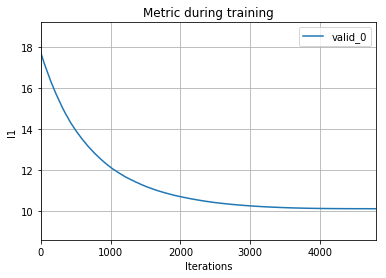

In [58]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='l1')
plt.show()

In [52]:
## lgbm much faster and showing better accuracy then xgboost so
## selected this algorithm for final results.
print('Starting predicting...')
# predict
y_pred = lgbm.predict(test_X, num_iteration=lgbm.best_iteration)
y_train_pred = lgbm.predict(train_X, num_iteration=lgbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(test_Y, y_pred) ** 0.5)
print('The rmse of prediction is:', mean_squared_error(train_Y, y_train_pred) ** 0.5)

Starting predicting...
The rmse of prediction is: 28.75008172153785
The rmse of prediction is: 27.447808417568105


In [0]:
data_test.drop(columns={'hits'}, inplace = True)

In [0]:
y_pred_test = lgbm.predict(data_test, num_iteration=lgbm.best_iteration)
df = pd.DataFrame()
df['row_num'] = data_test['row_num']
df['hits'] = y_pred_test

df.to_csv('data_test_prediction.csv')

**As we can see by using L1 regularization makes the training rmse larger than test rmse. Thus
making over-fitting minimum.**




In [0]:
train_features = [x for x in train_X.columns]
imp_df = pd.DataFrame()
imp_df["feature"] = list(train_features)
imp_df["importance_gain"] = lgbm.feature_importance(importance_type='gain')
imp_df["importance_split"] = lgbm.feature_importance(importance_type='split')
imp_df['trn_score'] = mean_squared_error(data_train['hits'], lgbm.predict(data_train[train_features]))**0.5

In [0]:
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.01 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.50      # feature_fraction 
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0

In [110]:
## Experimenting with k-crossvalidation
lgbm = lgb.cv(params, dtrain, num_boost_round=5000, early_stopping_rounds=100, nfold=3)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [111]:
print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(lgbm['l1-mean']))
print('Best CV score:', lgbm['l1-mean'][-1])

Current parameters:
 {'max_bin': 10, 'learning_rate': 0.01, 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'l1', 'sub_feature': 0.5, 'bagging_fraction': 0.85, 'bagging_freq': 40, 'num_leaves': 512, 'min_data': 500, 'min_hessian': 0.05, 'verbose': 0}

Best num_boost_round: 472
Best CV score: 10.347176878356175
